In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
import pickle

## "Затыкаем" предупреждения (от seaborn) - давайте будем честны, проект не доживет до момента, когда 
>`distplot` is a deprecated function and will be removed in a future version.

In [2]:
import warnings
warnings.filterwarnings('ignore')

Загрузим DataFrame, уберем ненужные столбцы (ID и пустой)

In [3]:
df = pd.read_csv('data.csv')
df = df.drop('Unnamed: 32', axis=1).drop("id", axis=1)

df.head()
# malignant - "bad"
# benign - "good"

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Убедимся, что в датасете нет ячеек с NaN

In [4]:
df.isnull().values.any()

False

Посмотрим типы данных, наименования столбцов

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    object 
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

# Немного графиков
## Отношение статистики по доброкачественным и злокачественым опухалям

B    357
M    212
Name: diagnosis, dtype: int64

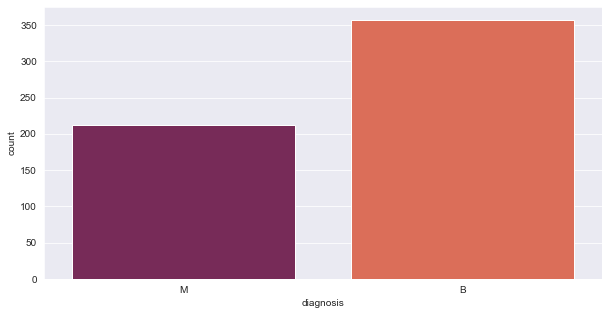

In [6]:
sns.set_style('darkgrid')
plt.figure(figsize=(10,5))
sns.countplot(x="diagnosis", data=df, palette='rocket');
pd.value_counts(df['diagnosis'])

## Построим тепловую карту корреляции значений

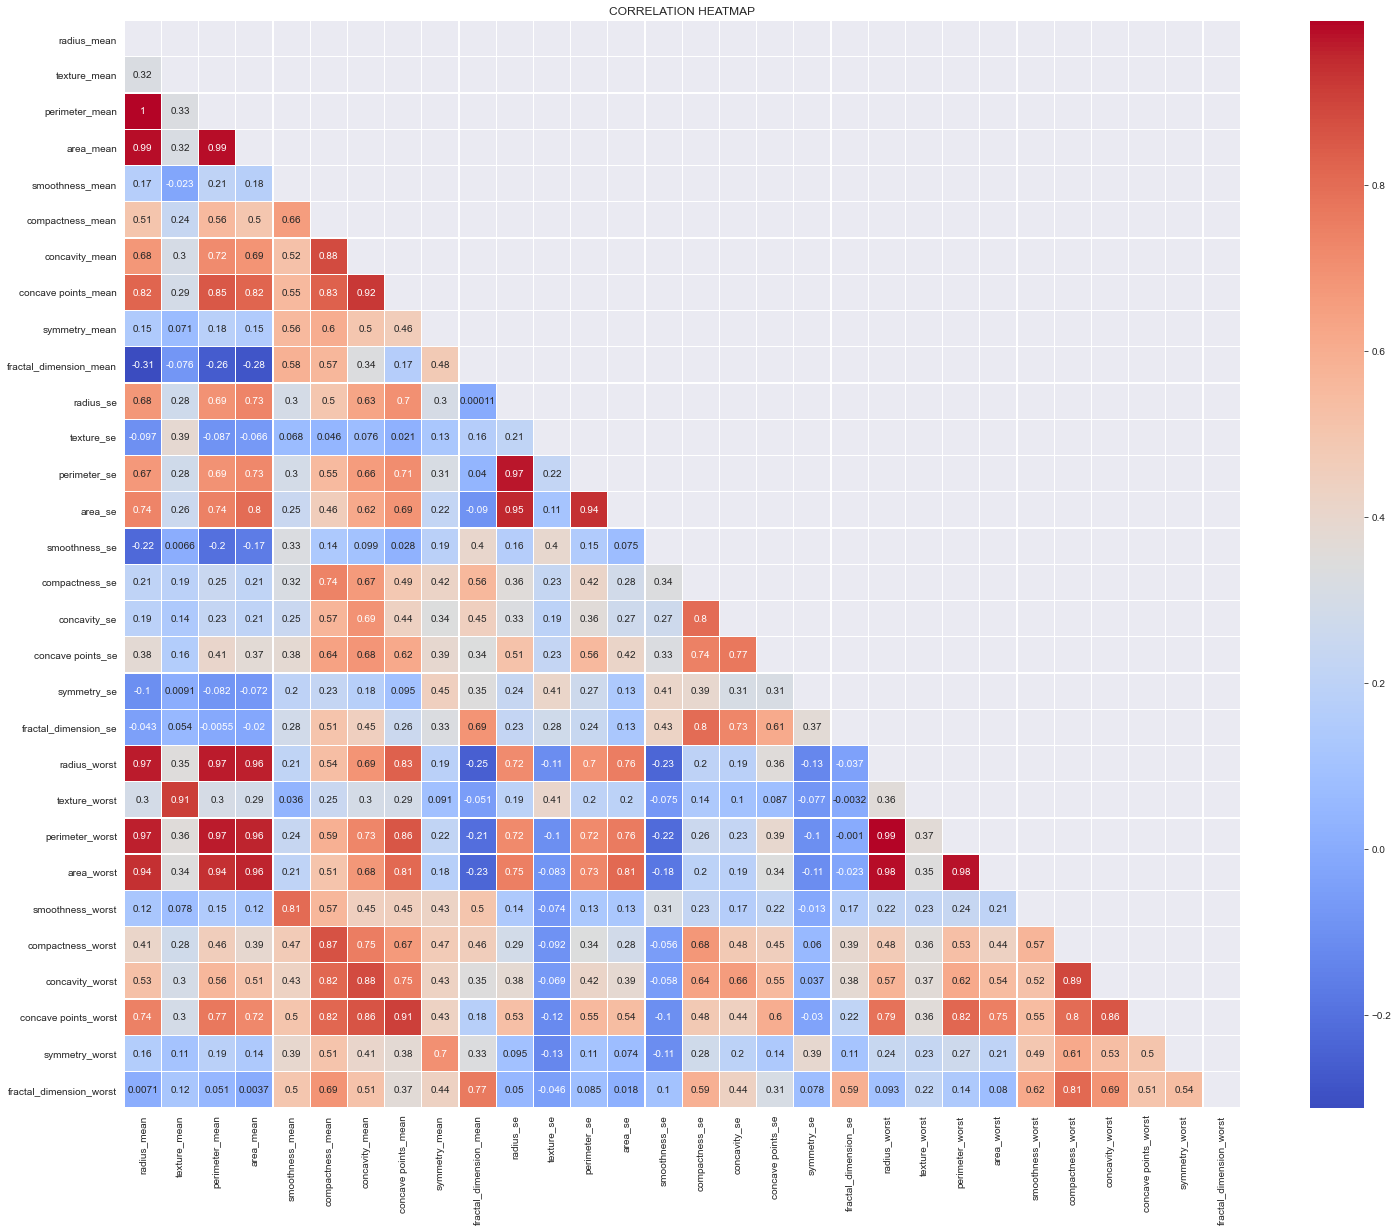

In [7]:
plt.figure(figsize=(25, 20))
plt.title("CORRELATION HEATMAP")
matrix = np.triu(df.corr())
sns.heatmap(df.corr(), annot=True, linewidth=.25, mask=matrix, cmap="coolwarm");

<AxesSubplot:xlabel='radius_mean', ylabel='texture_mean'>

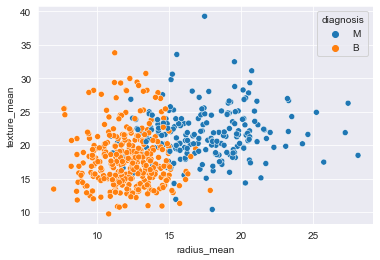

In [8]:
sns.scatterplot(x='radius_mean', y='texture_mean', hue='diagnosis', data=df)

<AxesSubplot:xlabel='smoothness_mean', ylabel='compactness_mean'>

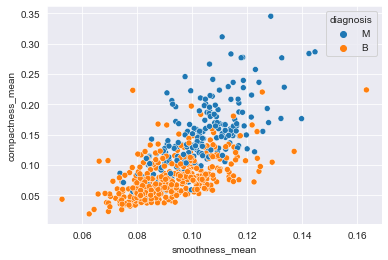

In [9]:
sns.scatterplot(x='smoothness_mean', y='compactness_mean', data=df, hue='diagnosis')

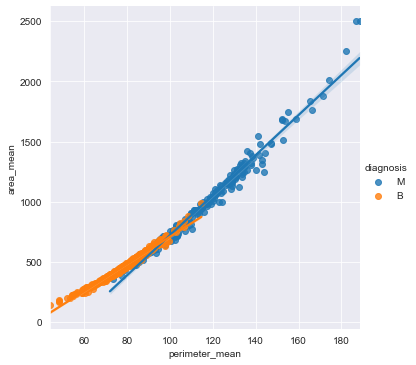

In [10]:
sns.lmplot(x='perimeter_mean', y='area_mean', data=df, hue='diagnosis')

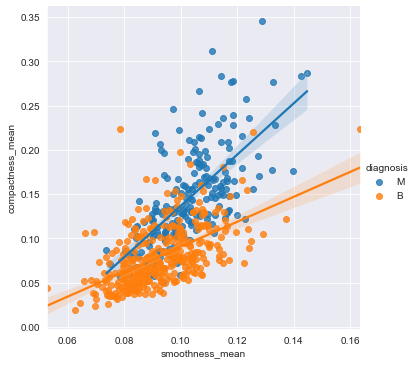

In [11]:
sns.lmplot(x='smoothness_mean', y='compactness_mean', data=df, hue='diagnosis')

##  Как можно увидеть, параметры area и perimetr имеют отношение к размеру

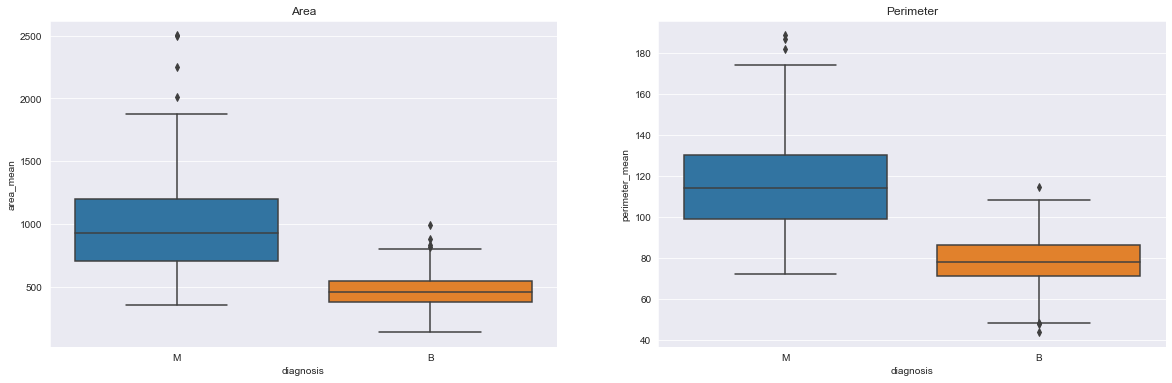

In [12]:
fig, table =  plt.subplots(1, 2, figsize=(20,6))
sns.boxplot(ax = table[0], x=df.diagnosis, y=df['area_mean'])
table[0].set_title('Area')

sns.boxplot(ax = table[1], x=df.diagnosis, y=df['perimeter_mean'])
table[1].set_title('Perimeter')

plt.show()

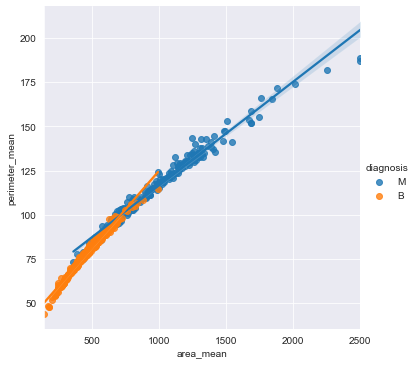

In [13]:
sns.lmplot(x='area_mean', y='perimeter_mean', data=df, hue='diagnosis')

In [14]:

bins = 5 #Number of bins is set to 20, bins are specified to divide the range of values into intervals
def histogram(features):
  plt.figure(figsize=(10,15))
  for i, feature in enumerate(features):
      plt.subplot(5, 2, i+1)  #subplot function: the number of rows are given as 5 and number of columns as 2, the value i+1 gives the subplot number, subplot numbers start with 1
      sns.distplot(df[df.diagnosis=='M'].drop("diagnosis",axis=1), bins=bins, color='red', label='Malignant');
      sns.distplot(df[df.diagnosis=='B'].drop("diagnosis",axis=1), bins=bins, color='green', label='Benign');
      plt.title(str(' Density Plot of:  ')+str(feature))
      plt.xlabel('X variable')
      plt.ylabel('Density Function')
      plt.legend(loc='upper right')
  plt.tight_layout()
  plt.show()


In [15]:
df.columns

Index(['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

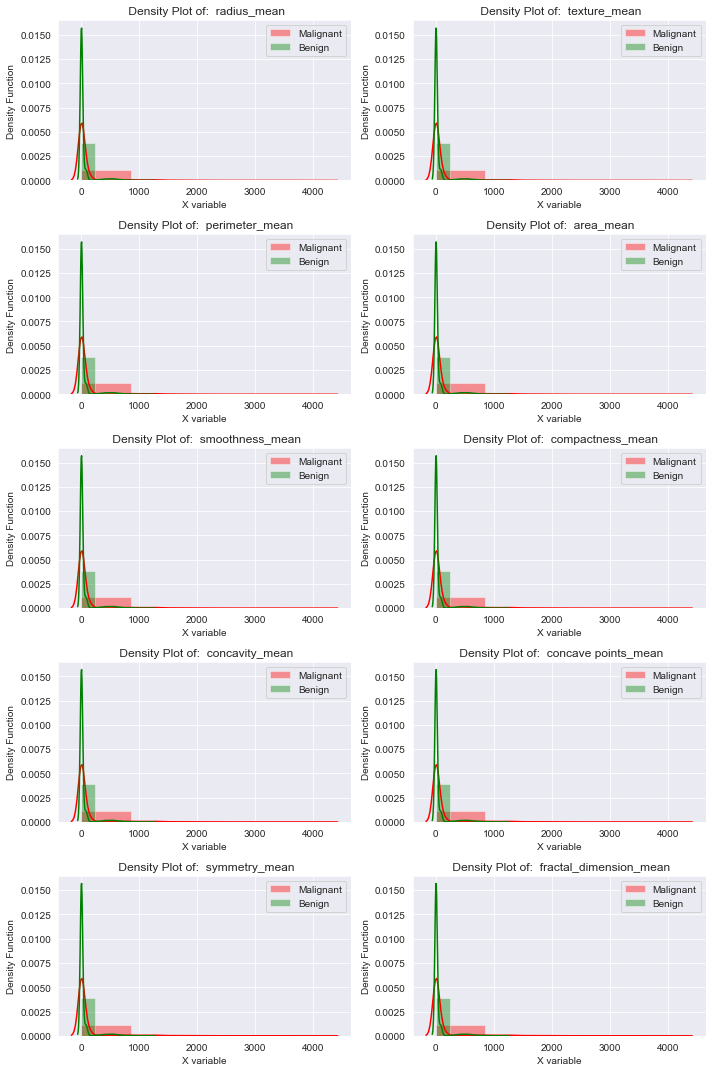

In [16]:
mean_features = list(filter(lambda x: "mean" in x, df.columns))  #['radius_mean', 'texture_mean']
histogram(mean_features)

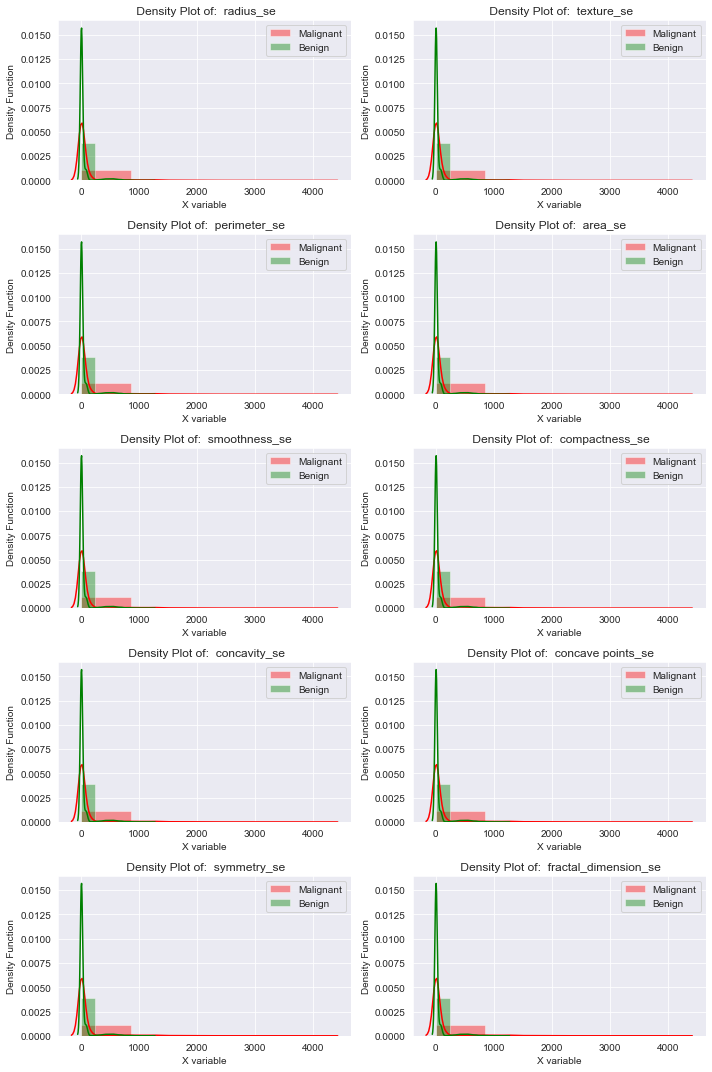

In [17]:
error_features = list(filter(lambda x: "_se" in x, df.columns))  #['radius_mean', 'texture_mean']
histogram(error_features)

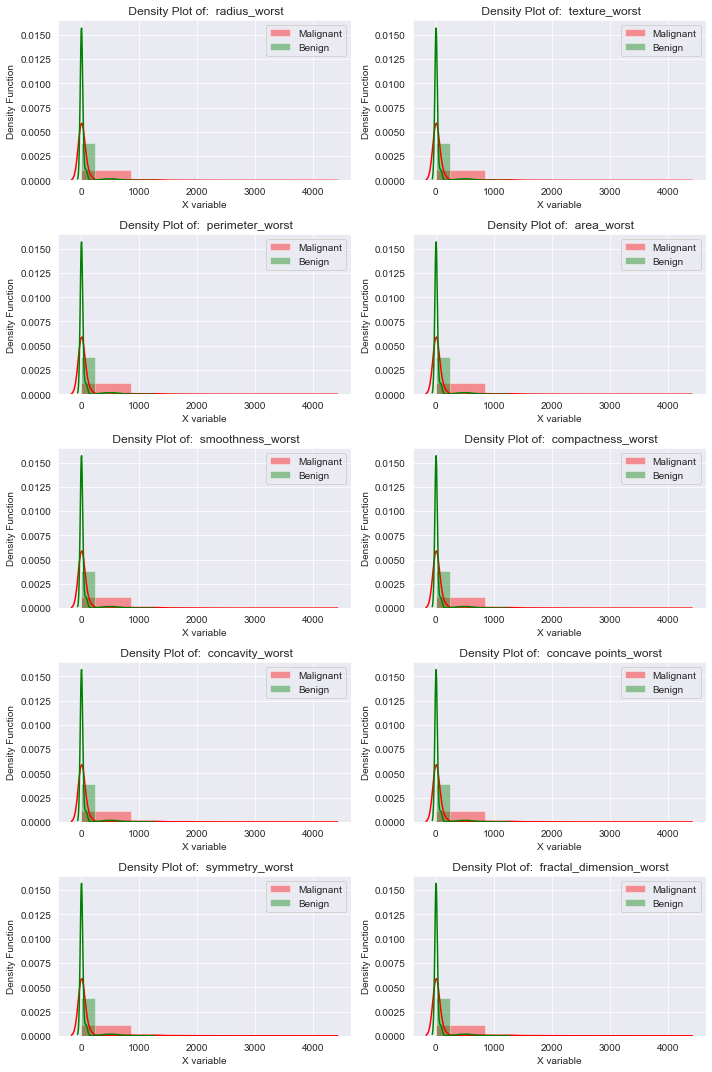

In [18]:
worst_features = list(filter(lambda x: "worst" in x, df.columns))  #['radius_mean', 'texture_mean']
histogram(worst_features)

##### Преобразуем Malignant и Benign в числа

In [19]:
# M - 1
# B - 0

print("B:", df.iloc[20]['diagnosis'])
print("M:", df.iloc[0]['diagnosis'])

le = LabelEncoder()
df['diagnosis'] = le.fit_transform(df['diagnosis'])

print("B:", df.iloc[20]['diagnosis'])
print("M:", df.iloc[0]['diagnosis'])

B: B
M: M
B: 0.0
M: 1.0


In [20]:
ss = StandardScaler()
cols = list(df)[1:]
df[cols] = ss.fit_transform(df[cols])

## Разделяем выборку (датасет) на 3 части

In [21]:
#street magic
train, test, validate = np.split(df.sample(frac=1, random_state=42), 
                       [int(.6*len(df)), int(.8*len(df))])

##### Отделяем "игреки" от "иксов"

In [22]:
separate = lambda x: (x['diagnosis'], x.drop("diagnosis",axis=1))

y_train, X_train = separate(train)
y_validate, X_validate = separate(validate)
y_test, X_test = separate(test)

y_full, X_full = separate(df)

##### Создаем, модель NN. Подбираем для нее параметры

In [23]:
rfc = RandomForestClassifier(random_state=0)
parameters = {
    'n_estimators': list(range(100,501,100)),
    'max_depth': list(range(2,10)),
    
}
cvgrid = GridSearchCV(estimator=rfc, param_grid=parameters,n_jobs=-1,verbose=3) 

In [24]:
cvgrid.fit(X_train,y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


GridSearchCV(estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9],
                         'n_estimators': [100, 200, 300, 400, 500]},
             verbose=3)

## Выбираем модель с лучшим показателем

In [25]:
cvgrid.best_estimator_

RandomForestClassifier(max_depth=3, n_estimators=200, random_state=0)

## Посмотрим процент "точных" предсказаний модели для разного кол-ва эпох

epoch:  1
epoch:  2
epoch:  3
epoch:  4
epoch:  5
epoch:  6
epoch:  7
epoch:  8
epoch:  9
Epochs: 9


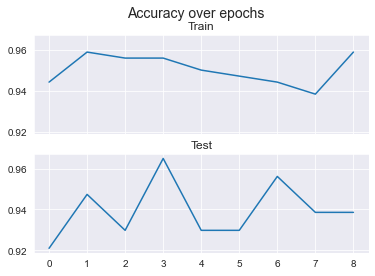

N: 4 0.9649122807017544


In [26]:
rfc_model = RandomForestClassifier(max_depth=2, n_estimators=200, random_state=0)
np.random.seed(0)

N_TRAIN_SAMPLES = X_train.shape[0]
N_EPOCHS = 9 # 12 # 4
N_BATCH = 128
N_CLASSES = np.unique(y_train)

scores_train = []
scores_test = []

# EPOCH
epoch = 0
while epoch < N_EPOCHS:
    print('epoch: ', epoch+1)
    # SHUFFLING
    random_perm = np.random.permutation(X_train.shape[0])
    mini_batch_index = 0
    while True:
        # MINI-BATCH
        indices = random_perm[mini_batch_index:mini_batch_index + N_BATCH]
        rfc_model.fit(X_train.iloc[indices], y_train.iloc[indices])
        mini_batch_index += N_BATCH

        if mini_batch_index >= N_TRAIN_SAMPLES:
            break

    # SCORE TRAIN
    scores_train.append(rfc_model.score(X_train, y_train))

    # SCORE TEST
    scores_test.append(rfc_model.score(X_test, y_test))

    epoch += 1
    pass

print('Epochs:', epoch)
fig, ax = plt.subplots(2, sharex=True, sharey=True)
ax[0].plot(scores_train)
ax[0].set_title('Train')
ax[1].plot(scores_test)
ax[1].set_title('Test')
fig.suptitle("Accuracy over epochs", fontsize=14)
plt.show()

m=max(scores_test)
print('N:',scores_test.index(m)+1, m)

<AxesSubplot:title={'center':'Train'}>

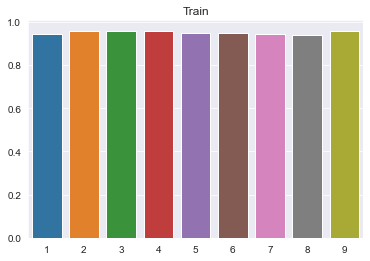

In [27]:
plt.title("Train")
sns.barplot(x=[i+1 for i in range(len(scores_train))],y=scores_train)

<AxesSubplot:title={'center':'Test'}>

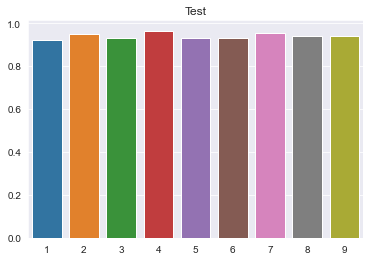

In [28]:
plt.title("Test")
sns.barplot(x=[i+1 for i in range(len(scores_test))],y=scores_test)

## Напоследок посмотрим на структурные единицы леса (деревья)
##### Разумеется, все 200 рассматривать не будем

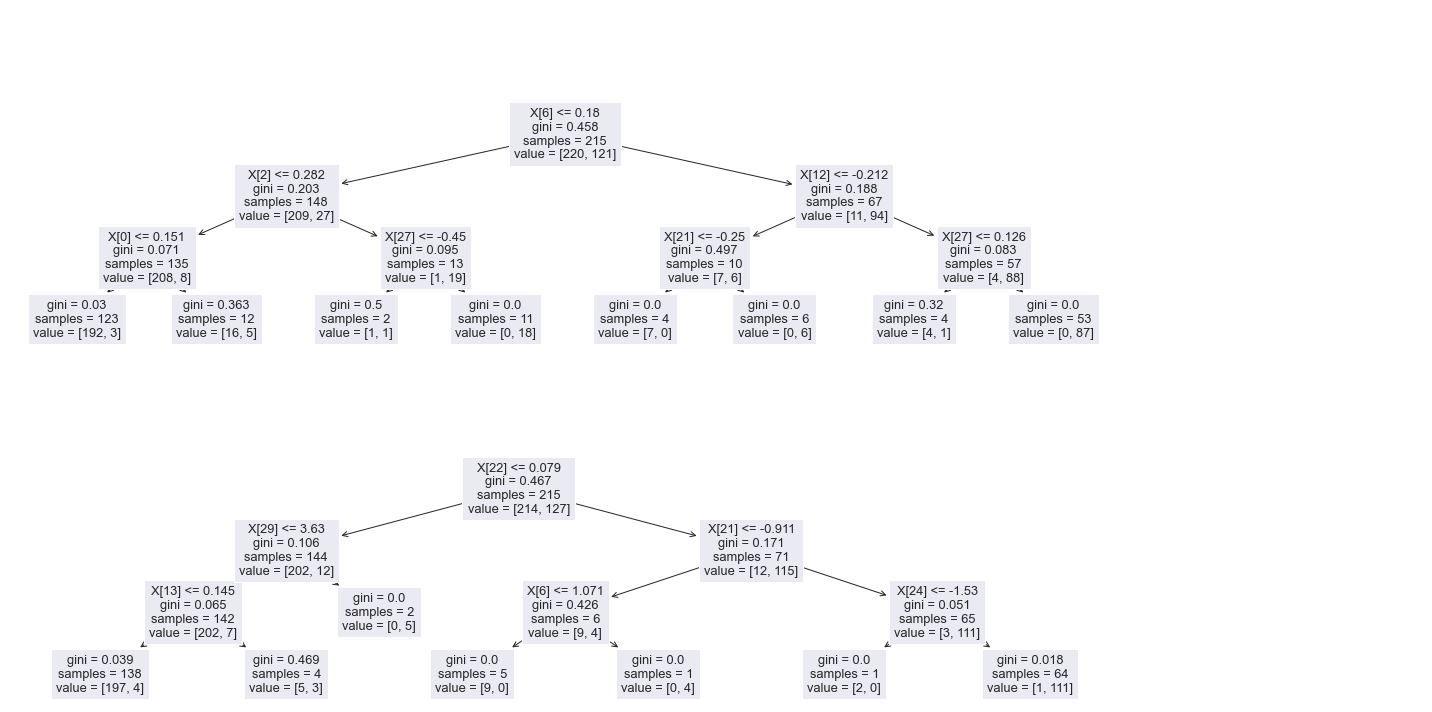

In [29]:
from sklearn import tree
plt.figure(figsize=(20,10))
for i in range(2):
    plt.subplot(2, 1, i+1)  #subplot function: the number of rows are given as 5 and number of columns as 2, the value i+1 gives the subplot number, subplot numbers start with 1
    tree.plot_tree(cvgrid.best_estimator_[i]) 
plt.tight_layout()
plt.show()

In [30]:
predicted = rfc_model.predict(X_validate)
aim=list(y_validate)
c=0
for i in range(len(aim)):
    if aim[i]==predicted[i]:
        c+=1
print(f"Accuracy:\t{round(100*c/len(aim), 2)}%\nMAE:\t\t{round(100*mean_absolute_error(y_validate, predicted), 2)}%")

Accuracy:	93.86%
MAE:		6.14%


In [31]:
model_fin = rfc_model # final model
with open("model.pckl", 'wb') as file:
    file.write(pickle.dumps(model_fin))
    
validate.to_csv('validate.csv')